In [33]:
import json
from pycocotools.coco import COCO
import os
import numpy as np
from pose_utils import world2cam, cam2pixel, pixel2cam, rigid_align, process_bbox
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
dir_joint = '/home/kiddhcx/Downloads/annotations/Human36M_subject1_joint_3d.json'
dir_data = '/home/kiddhcx/Downloads/annotations/Human36M_subject1_data.json'
dir_camera = '/home/kiddhcx/Downloads/annotations/Human36M_subject1_camera.json'

In [23]:
joint_num = 18
joints_name = ('Pelvis', 'R_Hip', 'R_Knee', 'R_Ankle', 'L_Hip', 'L_Knee', 'L_Ankle', 'Torso', 'Neck', 'Nose', 'Head', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'R_Shoulder', 'R_Elbow', 'R_Wrist', 'Thorax')
lshoulder_idx = joints_name.index('L_Shoulder')
rshoulder_idx = joints_name.index('R_Shoulder')
root_idx = joints_name.index('Pelvis')

In [24]:
def add_thorax(joint_coord):
    thorax = (joint_coord[lshoulder_idx, :] + joint_coord[rshoulder_idx, :]) * 0.5
    thorax = thorax.reshape((1, 3))
    joint_coord = np.concatenate((joint_coord, thorax), axis=0)
    return joint_coord

In [25]:
def load_data(dir_joint, dir_data, dir_camera):
    # aggregate annotations from each subject
    db = COCO()
    cameras = {}
    joints = {}
    
    # data load
    with open(dir_data,'r') as f:
        annot = json.load(f)
    if len(db.dataset) == 0:
        for k,v in annot.items():
            db.dataset[k] = v
    else:
        for k,v in annot.items():
            db.dataset[k] += v
    # camera load
    with open(dir_camera,'r') as f:
        cameras = json.load(f)
    # joint coordinate load
    with open(dir_joint, 'r') as f:
        joints = json.load(f)
    db.createIndex()

    data = []
    for aid in db.anns.keys():
        ann = db.anns[aid]
        image_id = ann['image_id']
        img = db.loadImgs(image_id)[0]
        img_width, img_height = img['width'], img['height']

        # camera parameter
        cam_idx = img['cam_idx']
        cam_param = cameras[str(cam_idx)]
        R,t,f,c = np.array(cam_param['R'], dtype=np.float32), np.array(cam_param['t'], dtype=np.float32), np.array(cam_param['f'], dtype=np.float32), np.array(cam_param['c'], dtype=np.float32)
            
        # project world coordinate to cam, image coordinate space
        action_idx = img['action_idx']; subaction_idx = img['subaction_idx']; frame_idx = img['frame_idx'];
        joint_world = np.array(joints[str(action_idx)][str(subaction_idx)][str(frame_idx)], dtype=np.float32)
        joint_world = add_thorax(joint_world)
        joint_cam = world2cam(joint_world, R, t)
        joint_img = cam2pixel(joint_cam, f, c)
        joint_img[:,2] = joint_img[:,2] - joint_cam[root_idx,2]
        joint_vis = np.ones((joint_num,1))
        

        bbox = process_bbox(np.array(ann['bbox']), img_width, img_height)
        if bbox is None: continue
        root_cam = joint_cam[root_idx]
            
        data.append({
            'img_id': image_id,
            'bbox': bbox,
            'joint_img': joint_img, # [org_img_x, org_img_y, depth - root_depth]
            'joint_cam': joint_cam, # [X, Y, Z] in camera coordinate
            'joint_vis': joint_vis,
            'root_cam': root_cam, # [X, Y, Z] in camera coordinate
            'f': f,
            'c': c})
        
    
    return data

In [26]:
d = load_data(dir_joint, dir_data, dir_camera)

creating index...
index created!


In [29]:
print(d[0]['root_cam'])
print(d[0]['joint_cam'])




[-176.73077 -321.04865 5203.882  ]
[[-176.73077  -321.04865  5203.882   ]
 [ -52.961914 -309.70453  5251.0825  ]
 [-155.64156    73.07172  5448.807   ]
 [ -29.831573  506.78442  5400.138   ]
 [-300.49985  -332.39282  5156.681   ]
 [-258.24048    99.60901  5244.681   ]
 [-209.48436   548.8338   5290.7637  ]
 [-109.15762  -529.7282   5123.8906  ]
 [-140.19118  -780.1214   5074.6045  ]
 [-153.1819   -886.97626  5130.165   ]
 [-118.93483  -970.22845  5058.5986  ]
 [-259.08997  -690.1336   5050.592   ]
 [-370.67087  -448.59937  5134.1772  ]
 [-462.28662  -290.82953  5307.6274  ]
 [ -19.760376 -716.91815  5140.2725  ]
 [  35.791595 -470.14496  5257.7383  ]
 [  13.892456 -279.85303  5421.0684  ]
 [-139.42517  -703.52594  5095.432   ]]


In [30]:
H36M_NAMES = ['']*18
H36M_NAMES[0]  = 'Pelvis'
H36M_NAMES[1]  = 'R_Hip'
H36M_NAMES[2]  = 'R_Knee'
H36M_NAMES[3]  = 'R_Ankle'
H36M_NAMES[4]  = 'L_Hip'
H36M_NAMES[5]  = 'L_Knee'
H36M_NAMES[6]  = 'L_Ankle'
H36M_NAMES[7] = 'Torso'
H36M_NAMES[8] = 'Neck'
H36M_NAMES[9] = 'Nose'
H36M_NAMES[10] = 'Head'
H36M_NAMES[11] = 'L_Shoulder'
H36M_NAMES[12] = 'L_Elbow'
H36M_NAMES[13] = 'L_Wrist'
H36M_NAMES[14] = 'R_Shoulder'
H36M_NAMES[15] = 'R_Elbow'
H36M_NAMES[16] = 'R_Wrist'
H36M_NAMES[17] = 'Thorax'

['Pelvis', 'R_Hip', 'R_Knee', 'R_Ankle', 'L_Hip', 'L_Knee', 'L_Ankle', 'Torso', 'Neck', 'Nose', 'Head', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'R_Shoulder', 'R_Elbow', 'R_Wrist', 'Thorax']


In [73]:
right_ankle = d[0]['joint_cam'][3]
print(right_ankle)

[ -29.831573  506.78442  5400.138   ]


In [112]:
def drawskeleton(channels, ax, lcolor='#ff0000', rcolor='#0000ff'):
    vals = channels
    connections = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5],
                       [5, 6], [0, 7], [7, 8], [8, 9], [9, 10],
                       [8, 11], [11, 12], [12, 13], [8, 14], [14, 15], [15, 16], [7,17]]

    LR = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1], dtype=bool)

    for ind, (i,j) in enumerate(connections):
        x, y, z = [np.array([vals[i, c], vals[j, c]]) for c in range(3)]
        ax.plot3D(x, y, z, lw=2, c=lcolor if LR[ind] else rcolor)

    
    xroot, yroot, zroot = vals[0, 0], vals[0, 1], vals[0, 2]
    print(xroot)
    ax.set_xlim3d([-500 + xroot, 500 + xroot])
    ax.set_zlim3d([-100 + zroot, 500 + zroot])
    ax.set_ylim3d([-1000 + yroot, 1000+ yroot])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


-176.73077


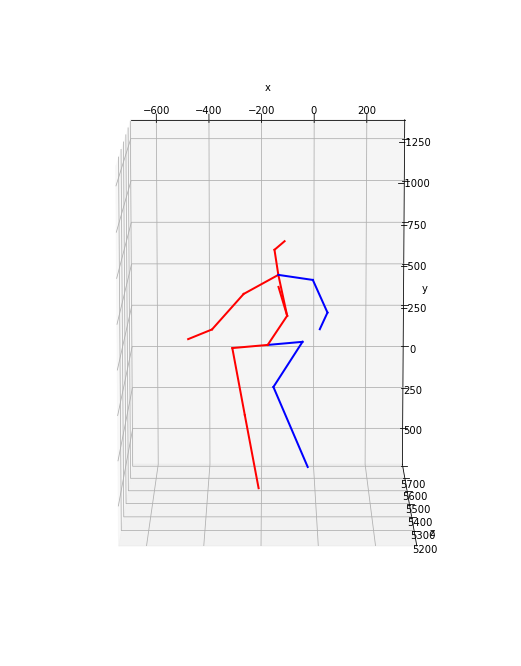

In [113]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot('121', projection='3d')
img = d[0]['joint_cam']
drawskeleton(img, ax)
ax.view_init(-80,-90)